In [120]:
import open3d as o3d
import numpy as np
import os
from tqdm import tqdm
#import tensorflow as tf
import random
import matplotlib.pyplot as plt

## Fix your path here

In [121]:
filepath = ["data/female", "data/male"]

In [122]:
# data_paths = filepath

# N = 5

# pcds_females = []
# pcds_males = []
# pcds = [pcds_females, pcds_males]

# for data in range(len(data_paths)):
#     files = []
#     folder_to_view = data_paths[data]

#     list = pcds[data]
#     for file in os.listdir(folder_to_view):
#         files.append(file)
#     for i in tqdm(range(N)):
#         file = (folder_to_view + "/" + str(files[i]))
#         mesh = o3d.io.read_triangle_mesh(file)
#         vertices = np.asarray(mesh.vertices)
#         center = vertices.mean(axis=0)
#         vertices -= center
#         mesh.vertices = o3d.utility.Vector3dVector(vertices)
#         mesh.get_center()
#         pcd = mesh.sample_points_uniformly(2048)
#         #pcd = pcd.voxel_down_sample(voxel_size=0.5)
#         list.append(pcd)

In [123]:
def Load_data(filepath, N): 
    # function takes filepath to data folder, and number of objects we want to load
    pcds_females = []
    pcds_males = []
    pcds = [pcds_males, pcds_females]
    for folder in range(len(filepath)):
        objects = []
        folder_to_view = filepath[folder]
        for object in os.listdir(folder_to_view):
            objects.append(object) #appends all objects to either female or male folder
        for i in tqdm(range(N)):
            file = (folder_to_view + "/" + str(objects[i])) #iterates over each object

            mesh = o3d.io.read_triangle_mesh(file) #load each object as mesh
            #cetralises each mesh object
            vertices = np.asarray(mesh.vertices)
            center = vertices.mean(axis=0)
            vertices -= center
            mesh.vertices = o3d.utility.Vector3dVector(vertices)

            #converts mesh to pcd and downsamples to 2048 points
            pcd = mesh.sample_points_uniformly(2048)

            pcds[folder].append(pcd)

    return pcds_females, pcds_males, pcds

### Normals

In [124]:
pcds_females, pcds_males, pcds = Load_data(filepath=filepath, N = 5)

100%|██████████| 5/5 [00:00<00:00, 21.99it/s]


In [125]:
def Get_normals(pcds_females): 
    normals = []
    for i in range(len(pcds_females)):
        normals.append(np.asarray(pcds_females[i].normals))
    return normals
normalerne = Get_normals(pcds_females)

np.shape(normalerne[0])

(2048, 3)

### Convert to numpy array

In [126]:
pcds_females_arr = []
pcds_males_arr = []
pcds_arr = [pcds_females_arr, pcds_males_arr]


for points in range(len(pcds)): 
    for i in tqdm(range(len(pcds_females))):
        pcds_arr[points].append(np.asarray(pcds[points][i].points) )



100%|██████████| 5/5 [00:00<00:00, 51025.60it/s]


In [127]:
furthest_distance = 0

for points in range(len(pcds_arr)): 
    for i in range(len(pcds_males_arr)):
        distance = np.max(np.sqrt(np.sum(abs(pcds_arr[points][i])**2,axis=1)))
        if distance > furthest_distance:
            furthest_distance = distance
            
furthest_distance

0.9907830883265987

### Normalize (Update to normalize in regards to biggest person)

In [128]:
def normalize(points): # The input of this function is a point cloud object
    # This function normalizes a point cloud within a unit sphere
    points = np.asarray(points.points) 
    centroid = np.mean(points, axis=0)
    points -= centroid
    points / furthest_distance
    return points # The function return a numpy array of dimension nx3 where the points are normalized within a unit sphere

pcds_females_arr_norm = []
pcds_males_arr_norm = []
pcds_arr_norm = [pcds_females_arr_norm, pcds_males_arr_norm]


for points in range(len(pcds_arr)):
    for i in tqdm(range(len(pcds_females))):
        pcds_arr_norm[points].append(normalize(pcds[points][i]))

100%|██████████| 5/5 [00:00<00:00, 5223.29it/s]


In [129]:
furthest_distance = 0

for points in range(len(pcds_arr_norm)): 
    for i in range(len(pcds_males_arr)):
        distance = np.max(np.sqrt(np.sum(abs(pcds_arr_norm[points][i])**2,axis=1)))
        if distance > furthest_distance:
            furthest_distance = distance
            
furthest_distance

0.9783446727681298

# Centraliser

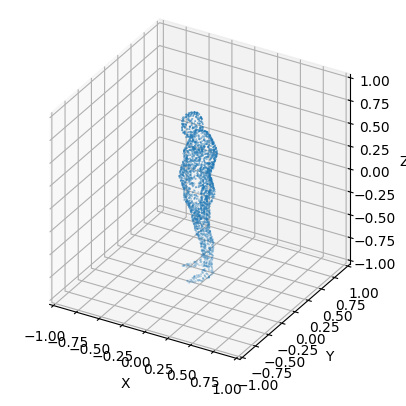

In [130]:
def visualize(points):
    points = np.asarray(points.points)

    # Plot it using matplotlib with tiny points and constrained axes
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_box_aspect((1,1,1)) # Constrain the axes
    ax.set_proj_type('ortho') # Use orthographic projection
    ax.set_xlim(-1,1) # Set x-axis range
    ax.set_ylim(-1,1) # Set y-axis range
    ax.set_zlim(-1,1) # Set z-axis range
    plt.show()


visualize(pcds_females[2])

# Augmentation

### Rotation

In [131]:
test_person = pcds_females[2]

In [132]:
# Define the maximum angle in degrees for the random rotation
max_angle = 45

mesh = o3d.io.read_triangle_mesh("data/female/SPRING0060.obj")
# Generate a random rotation axis and angle
axis = np.random.uniform(-1, 1, 3)
axis /= np.linalg.norm(axis)
angle = np.random.uniform(-max_angle, max_angle) * np.pi / 180  # convert degrees to radians

# Create the rotation matrix using Open3D's utility function
#rot_matrix = o3d.geometry.get_rotation_matrix_from_axis_angle(axis, angle)

R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, np.pi / 2, np.pi / 2))


# Apply the rotation to the point cloud using Open3D's built-in transform function
test_rotate = test_person.rotate(R)

### To visualise point cloud

In [133]:
#o3d.visualization.draw_geometries([test_person,pcds_males[2]])